# [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)

https://www.kaggle.com/code/vbmokin/titanic-top-score-one-line-of-the-prediction/notebook?scriptVersionId=103861171

![](https://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg)

## Titanic : one lines of the prediction code for LB = 0.80382

Now I will give a code with forecasting not in the context of the classes of cabins and ports, but in the context of the surnames of passengers (Thanks to: https://www.kaggle.com/mauricef/titanic). 


It is interesting that there are obvious data errors in the dataset (for example, with respect to the Andersson (see https://www.kaggle.com/c/titanic/discussion/14904#latest-208058), who are not all the same family, and lived in several different cabins), but if they are corrected, the forecast will worsen!

After the code, I will show how this one line of prediction code was developed.

Thanks to:

* [Automatic selection from 20 classifier models](https://www.kaggle.com/vbmokin/automatic-selection-from-20-classifier-models)
* [Titanic (0.83253) - Comparison 20 popular models](https://www.kaggle.com/vbmokin/titanic-0-83253-comparison-20-popular-models)
* [Three lines of code for Titanic Top 15%](https://www.kaggle.com/vbmokin/three-lines-of-code-for-titanic-top-15)
* [Three lines of code for Titanic Top 20%](https://www.kaggle.com/vbmokin/three-lines-of-code-for-titanic-top-20)
* [Titanic Top 3% : cluster analysis](https://www.kaggle.com/vbmokin/titanic-top-3-cluster-analysis)
* [Feature importance - xgb, lgbm, logreg, linreg](https://www.kaggle.com/vbmokin/feature-importance-xgb-lgbm-logreg-linreg)

In [103]:
# Download data and preparing to prediction (including FE) 
# Thanks to: https://www.kaggle.com/mauricef/titanic
import pandas as pd
import numpy as np 
PATH = '../data'
traindf = pd.read_csv(f'{PATH}/train.csv').set_index('PassengerId')
testdf = pd.read_csv(f'{PATH}/test.csv').set_index('PassengerId')

In [121]:
df = pd.concat([traindf, testdf], axis=0, sort=False).copy()
df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]
df = df.sort_values(['LastName'], ascending=True)

family = df.groupby(df.LastName).Survived
df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)['WomanOrBoyCount']

df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)['FamilySurvivedCount']

df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)

df['Alone'] = (df.WomanOrBoyCount == 0)
train_y = df.Survived.loc[traindf.index]
df = pd.concat([df.WomanOrBoySurvived.fillna(0), df.Alone, df.Sex.replace({'male': 0, 'female': 1})], axis=1)

test_x = df.loc[testdf.index]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount
PassengerId,,,,,,,,,,,,,,,
846,0.0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.55,NaN,S,Mr,False,Abbing,0
1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.25,NaN,S,Master,True,Abbott,1
747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.25,NaN,S,Mr,False,Abbott,2
280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.25,NaN,S,Mrs,True,Abbott,1
949,NaN,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.65,F G63,S,Mr,False,Abelseth,1


In [125]:
# My upgrade - the one line of the code for prediction : LB = 0.83253 (Titanic Top 3%) 
test_x['Survived'] = (((test_x.WomanOrBoySurvived <= 0.238) & (test_x.Sex > 0.5) & (test_x.Alone > 0.5)) | \
          ((test_x.WomanOrBoySurvived > 0.238) & \
           ~((test_x.WomanOrBoySurvived > 0.55) & (test_x.WomanOrBoySurvived <= 0.633))))

In [134]:
from datetime import datetime
import os

submission = pd.DataFrame({
    'Survived': test_x['Survived'].astype(int)
    }, index=testdf.index
).reset_index()
filename = f'''../submission/submit_{datetime.now().strftime('%Y%m%d_%H%M')}.csv'''
# submission.to_csv(filename, index=False)
# os.system(f'''kaggle competitions submit -c titanic -f {filename} -m {filename}''')

100%|██████████| 2.77k/2.77k [00:02<00:00, 1.11kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster

0

# Tuning the model

### Download data and preparing to prediction (including FE) 

In [135]:
import pandas as pd
import numpy as np 
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import warnings
warnings.filterwarnings("ignore")

In [136]:
# Download data and preparing to prediction (including FE) 
traindf = pd.read_csv('../data/train.csv').set_index('PassengerId')
testdf = pd.read_csv('../data/test.csv').set_index('PassengerId')
df = pd.concat([traindf, testdf], axis=0, sort=False)

In [137]:
# FE
# df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
# df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
# df['LastName'] = df.Name.str.split(',').str[0]
# family = df.groupby(df.LastName).Survived
# df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
# df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
# df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
# df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
# df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
# df['Alone'] = (df.WomanOrBoyCount == 0)

df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
df['LastName'] = df.Name.str.split(',').str[0]
df = df.sort_values(['LastName'], ascending=True)

family = df.groupby(df.LastName).Survived
df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)['WomanOrBoyCount']

df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)['FamilySurvivedCount']

df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)

df['Alone'] = (df.WomanOrBoyCount == 0)

In [138]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsWomanOrBoy,LastName,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone
PassengerId,,,,,,,,,,,,,,,,,,
846,0.0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,NaN,S,Mr,False,Abbing,0,0.0,NaN,True
1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.2500,NaN,S,Master,True,Abbott,1,1.0,1.0,False
747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,Mr,False,Abbott,2,1.0,0.5,False
280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,Mrs,True,Abbott,1,0.0,0.0,False
949,NaN,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,F G63,S,Mr,False,Abelseth,1,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C,Mr,False,del Carlo,1,0.0,0.0,False
154,0.0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S,Mr,False,van Billiard,2,0.0,0.0,False
1236,NaN,3,"van Billiard, Master. James William",male,NaN,1,1,A/5. 851,14.5000,NaN,S,Master,True,van Billiard,1,0.0,0.0,False


In [139]:
train_y = df.Survived.loc[traindf.index]
data = pd.concat([df.WomanOrBoySurvived.fillna(0), df.Alone, \
                  df.Sex.replace({'male': 0, 'female': 1})], axis=1)
train_x, test_x = data.loc[traindf.index], data.loc[testdf.index]
train_x.head(5)

,WomanOrBoySurvived,Alone,Sex
PassengerId,,,
1,0.0,True,0
2,0.0,True,1
3,0.0,True,1
4,0.0,True,1
5,1.0,False,0


### Tuning model

In [140]:
# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {'max_depth' : np.arange(2, 5, dtype=int),
              'min_samples_leaf' :  np.arange(2, 5, dtype=int)}
classifier = DecisionTreeClassifier(random_state=1000)
model = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=2, n_jobs=-1)
model.fit(train_x, train_y)
best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 4, 'min_samples_leaf': 2}


In [141]:
model=DecisionTreeClassifier(max_depth = best_parameters['max_depth'], 
                             random_state = 1000)
model.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=4, random_state=1000)

### Plot tree

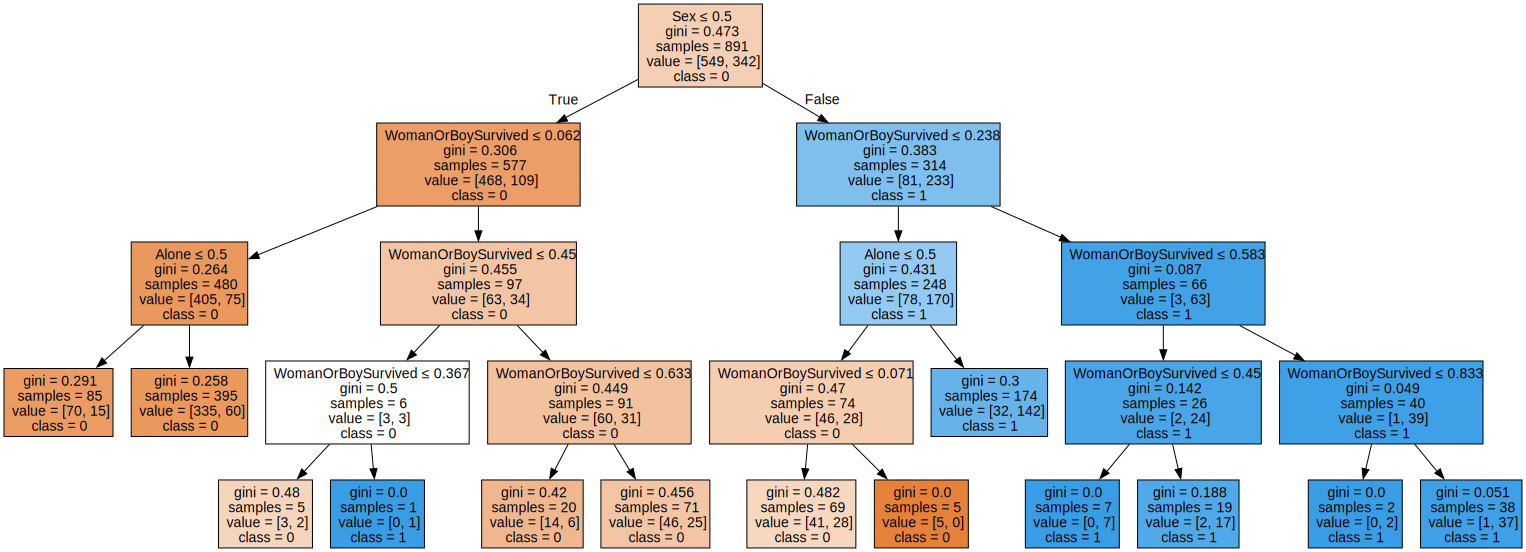

In [142]:
# plot tree
dot_data = export_graphviz(model, out_file=None, feature_names=train_x.columns, class_names=['0', '1'], 
                           filled=True, rounded=False,special_characters=True, precision=3) 
graph = graphviz.Source(dot_data)
graph 

### Prediction

In [143]:
# # Prediction by the DecisionTreeClassifier
y_pred = model.predict(test_x).astype(int)
print('Mean =', y_pred.mean(), ' Std =', y_pred.std())

Mean = 0.3157894736842105  Std = 0.464829519280413


In [146]:
# The one line of the code for prediction : LB = 0.80382 (Titanic Top 6%) 
test_x['Survived'] = (((test_x.WomanOrBoySurvived <= 0.238) & (test_x.Sex > 0.5) & (test_x.Alone > 0.5)) | \
                      ((test_x.WomanOrBoySurvived > 0.238) & \
                       ~((test_x.WomanOrBoySurvived > 0.55) & (test_x.WomanOrBoySurvived <= 0.633))))
y_pred = test_x['Survived'].astype(int)
print('Mean =', y_pred.mean(), ' Std =', y_pred.std())

Mean = 0.4354066985645933  Std = 0.496404291168754


As you can see there is a slight difference in std, possibly related to the fact that the rules on the decision tree are shown with rounding. But this did not affect the accuracy of the solution, at least the first 5 decimal places in the Kaggle leaderboard

### Saving the result

In [147]:
# # Saving the result
# pd.DataFrame({'Survived': y_pred}, index=testdf.index).reset_index().to_csv('../submission/submission.csv', index=False)

In [148]:
from datetime import datetime
import os

submission = pd.DataFrame({
    'Survived': y_pred
    }, index=testdf.index
).reset_index()
filename = f'''../submission/submit_{datetime.now().strftime('%Y%m%d_%H%M')}.csv'''
submission.to_csv(filename, index=False)
os.system(f'''kaggle competitions submit -c titanic -f {filename} -m {filename}''')

100%|██████████| 2.77k/2.77k [00:02<00:00, 1.35kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster

0